In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50, DenseNet121, MobileNetV3Large
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Mean
from sklearn.metrics import precision_recall_curve, average_precision_score
import time
import pickle

In [ ]:
# Step 1: Load and Preprocess Data
# Assume `train_dir` and `validation_dir` are directories with your training and validation data

img_size = (224, 224)
batch_size = 16

train_dir=(r'C:\Users\Irfan\Desktop\Degree\Sem 4\AI\Mini Project\Butterfly\train')
validation_dir=(r'C:\Users\Irfan\Desktop\Degree\Sem 4\AI\Mini Project\Butterfly\val')
test_dir=(r'C:\Users\Irfan\Desktop\Degree\Sem 4\AI\Mini Project\Butterfly\test')

train_datagen = ImageDataGenerator(rescale=1./255)
train_generator = train_datagen.flow_from_directory(train_dir, target_size=img_size, batch_size=batch_size, class_mode='categorical')

validation_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_directory(validation_dir, target_size=img_size, batch_size=batch_size, class_mode='categorical')

test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(test_dir, target_size=img_size, batch_size=batch_size, class_mode='categorical')

Found 8728 images belonging to 5 classes.
Found 1857 images belonging to 5 classes.
Found 3419 images belonging to 5 classes.


In [ ]:
# Step 2: Define and Compile the Models
def create_model(base_model):
    model = models.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Dense(train_generator.num_classes, activation='softmax')
    ])
    model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

models_dict = {
    'ResNet50': ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3)),
    'DenseNet121': DenseNet121(weights='imagenet', include_top=False, input_shape=(224, 224, 3)),
    'MobileNetV3': MobileNetV3Large(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
}

In [ ]:
# Step 3: Train the Models and Record Training Time
# Train each model and save the models
train_histories = {}
training_times = {}

for model_name, base_model in models_dict.items():
    print(f"Training {model_name}...")
    model = create_model(base_model)

    start_time = time.time()
    history = model.fit(train_generator, validation_data=validation_generator, epochs=50)
    training_time = time.time() - start_time

    train_histories[model_name] = history.history
    training_times[model_name] = training_time
    model.save(f'C:\\Users\\Irfan\\Desktop\\Degree\\Sem 4\\AI\\Mini Project\\Butterfly\\{model_name}_model.h5')
    print(f"{model_name} training completed in {training_time:.2f} seconds.")

# Save the training histories and training times
with open('train_histories.pkl', 'wb') as f:
    pickle.dump(train_histories, f)

with open('training_times.pkl', 'wb') as f:
    pickle.dump(training_times, f)

Training ResNet50...
Epoch 1/50
546/546 [==============================] - 91s 158ms/step - loss: 1.0645 - accuracy: 0.6253 - val_loss: 1.8169 - val_accuracy: 0.2019
Epoch 2/50
546/546 [==============================] - 79s 144ms/step - loss: 0.6380 - accuracy: 0.7747 - val_loss: 1.1854 - val_accuracy: 0.6295
Epoch 3/50
546/546 [==============================] - 79s 144ms/step - loss: 0.5205 - accuracy: 0.8189 - val_loss: 0.6866 - val_accuracy: 0.7561
Epoch 4/50
546/546 [==============================] - 79s 145ms/step - loss: 0.4600 - accuracy: 0.8388 - val_loss: 0.5769 - val_accuracy: 0.7889
Epoch 5/50
546/546 [==============================] - 79s 144ms/step - loss: 0.3897 - accuracy: 0.8662 - val_loss: 0.7118 - val_accuracy: 0.7684
Epoch 6/50
546/546 [==============================] - 79s 145ms/step - loss: 0.3675 - accuracy: 0.8740 - val_loss: 0.6512 - val_accuracy: 0.7830
Epoch 7/50
546/546 [==============================] - 79s 144ms/step - loss: 0.3153 - accuracy: 0.8897 - val_

In [ ]:
# Step 4: Evaluate the Models
# Accuracy is already included in the training metrics. For mAP, you might need additional steps depending on your dataset and task.
# This is an example to calculate accuracy, as mAP calculation can be complex and dataset specific.

from tensorflow.keras.models import load_model

# Load the training histories and training times
with open('train_histories.pkl', 'rb') as f:
    train_histories = pickle.load(f)

with open('training_times.pkl', 'rb') as f:
    training_times = pickle.load(f)

mAP_results = {}

# Load models from the saved files and evaluate
for model_name, base_model in models_dict.items():
    print(f"Evaluating {model_name}...")

    # Load the saved model
    model = load_model(rf'C:\\Users\\Irfan\\Desktop\\Degree\\Sem 4\\AI\\Mini Project\\Butterfly\\{model_name}_model.h5')

    # Evaluate the model
    evaluation = model.evaluate(validation_generator)
    print(f"{model_name} - Loss: {evaluation[0]}, Accuracy: {evaluation[1]}")

    # Generate predictions for validation data
    y_true = validation_generator.classes
    y_pred = model.predict(validation_generator)

    # Calculate mAP
    APs = []
    for i in range(validation_generator.num_classes):
        precision, recall, _ = precision_recall_curve(y_true == i, y_pred[:, i])
        AP = average_precision_score(y_true == i, y_pred[:, i])
        APs.append(AP)
        print(f"{model_name} AP for class {i}: {AP:.4f}")

    mAP = np.mean(APs)
    mAP_results[model_name] = mAP
    print(f"{model_name} mAP: {mAP:.4f}")

# Print mAP results
for model_name, mAP in mAP_results.items():
    print(f"{model_name} mAP: {mAP:.4f}")

# Record the performance metrics
performance_metrics = {model_name: {'accuracy': hist['accuracy'][-1], 'val_accuracy': hist['val_accuracy'][-1]} for model_name, hist in train_histories.items()}
print(performance_metrics)

# Print training times with two decimal points and the word "seconds"
for model_name, training_time in training_times.items():
    print(f"{model_name}: {training_time:.2f} seconds")


Evaluating ResNet50...
117/117 [==============================] - 28s 169ms/step - loss: 0.5127 - accuracy: 0.8912
ResNet50 - Loss: 0.5127087831497192, Accuracy: 0.8912224173545837
117/117 [==============================] - 7s 49ms/step
ResNet50 AP for class 0: 0.2095
ResNet50 AP for class 1: 0.1901
ResNet50 AP for class 2: 0.1961
ResNet50 AP for class 3: 0.1976
ResNet50 AP for class 4: 0.1926
ResNet50 mAP: 0.1972
Evaluating DenseNet121...
117/117 [==============================] - 8s 51ms/step - loss: 0.3745 - accuracy: 0.8961
DenseNet121 - Loss: 0.3744954764842987, Accuracy: 0.8960689306259155
117/117 [==============================] - 7s 50ms/step
DenseNet121 AP for class 0: 0.1993
DenseNet121 AP for class 1: 0.1992
DenseNet121 AP for class 2: 0.2026
DenseNet121 AP for class 3: 0.1942
DenseNet121 AP for class 4: 0.2024
DenseNet121 mAP: 0.1995
Evaluating MobileNetV3...
117/117 [==============================] - 7s 47ms/step - loss: 2.3680 - accuracy: 0.2036
MobileNetV3 - Loss: 2.3680

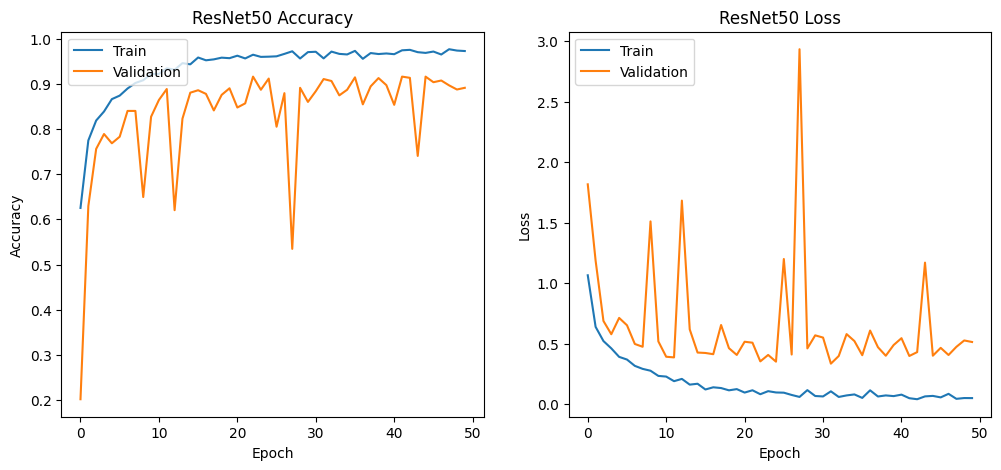

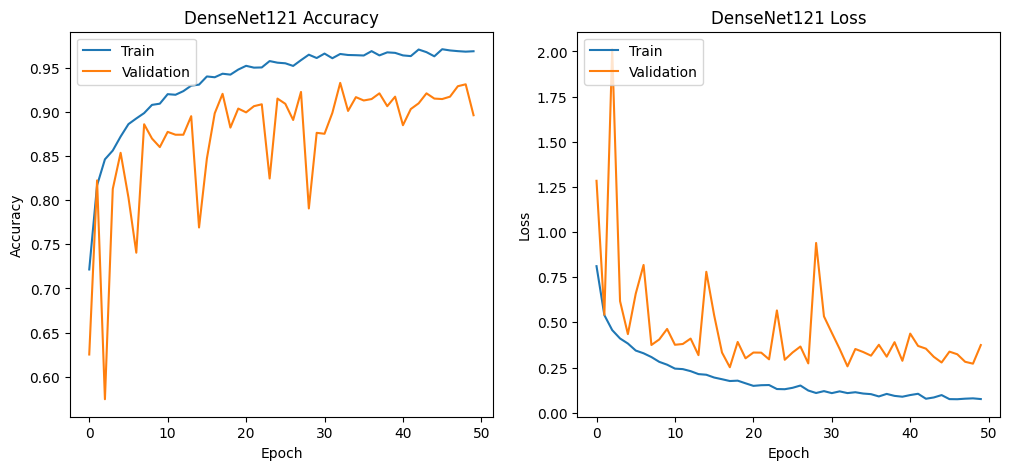

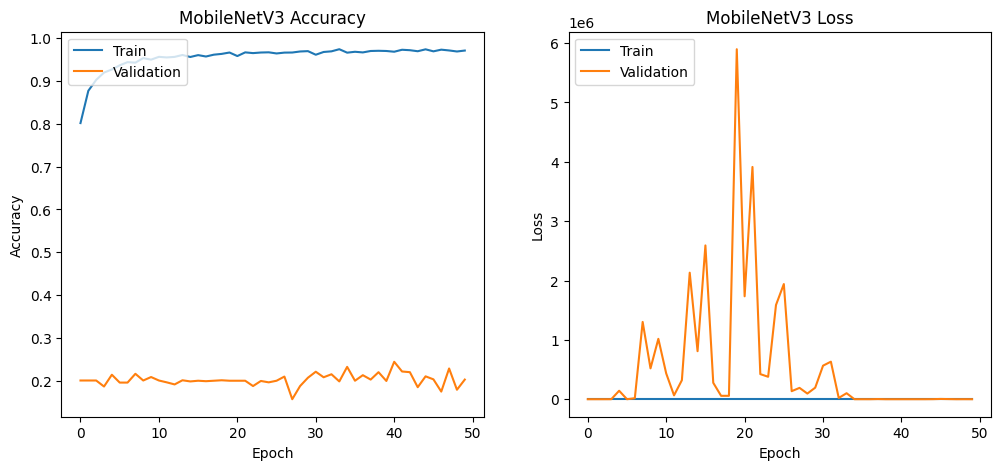

In [ ]:
import matplotlib.pyplot as plt

def plot_history(histories, model_name):
    plt.figure(figsize=(12, 5))

    # Plot training & validation accuracy values
    plt.subplot(1, 2, 1)
    plt.plot(histories['accuracy'])
    plt.plot(histories['val_accuracy'])
    plt.title(f'{model_name} Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    # Plot training & validation loss values
    plt.subplot(1, 2, 2)
    plt.plot(histories['loss'])
    plt.plot(histories['val_loss'])
    plt.title(f'{model_name} Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    plt.show()

# Plotting the histories
for model_name, history in train_histories.items():
    plot_history(history, model_name)


214/214 [==============================] - 31s 143ms/step


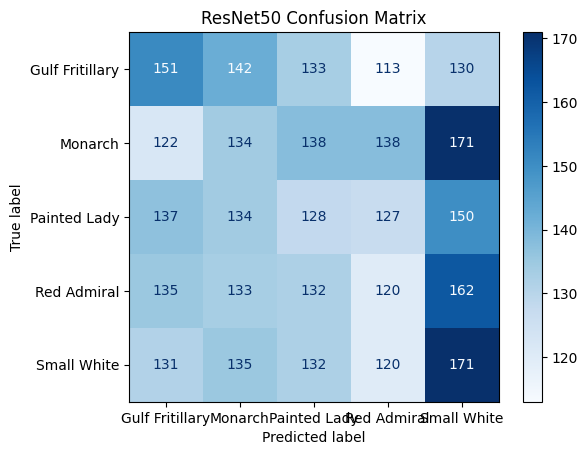

214/214 [==============================] - 12s 49ms/step


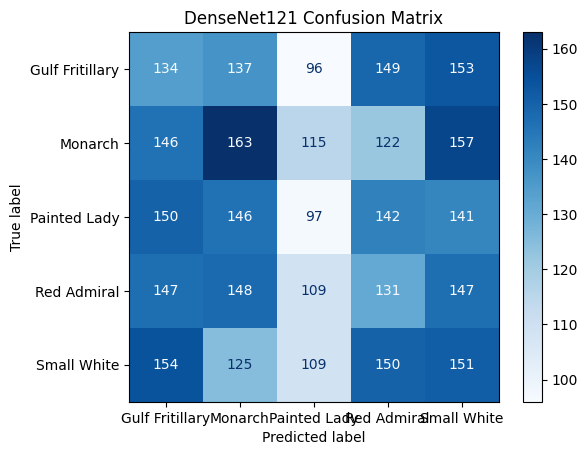

214/214 [==============================] - 11s 48ms/step


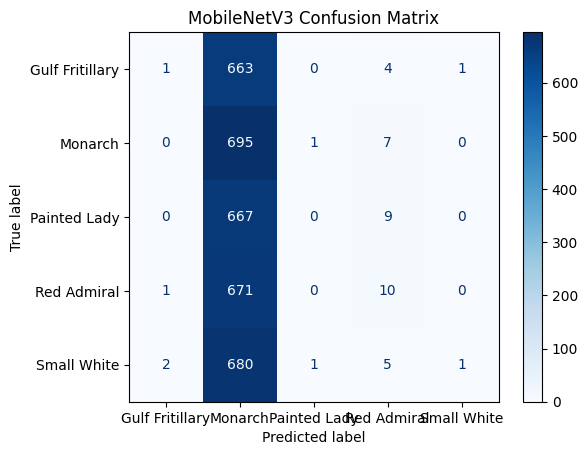

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def plot_confusion_matrix(model, model_name):
    y_true = test_generator.classes
    y_pred = model.predict(test_generator)
    y_pred_classes = np.argmax(y_pred, axis=1)

    cm = confusion_matrix(y_true, y_pred_classes)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=test_generator.class_indices.keys())

    disp.plot(cmap=plt.cm.Blues)
    plt.title(f'{model_name} Confusion Matrix')
    plt.show()

# Generate and plot confusion matrices for each model
for model_name in models_dict.keys():
    model = load_model(rf'C:\\Users\\Irfan\\Desktop\\Degree\\Sem 4\\AI\\Mini Project\\Butterfly\\{model_name}_model.h5')
    plot_confusion_matrix(model, model_name)


In [ ]:
# Evaluate the models on the test dataset and calculate mAP
mAP_results = {}

for model_name in models_dict.keys():
    print(f"Evaluating {model_name}...")
    model = load_model(rf'C:\\Users\\Irfan\\Desktop\\Degree\\Sem 4\\AI\\Mini Project\\Butterfly\\{model_name}_model.h5')

    evaluation = model.evaluate(test_generator)
    print(f"{model_name} - Loss: {evaluation[0]}, Accuracy: {evaluation[1]}")

    y_true = test_generator.classes
    y_pred = model.predict(test_generator)

    APs = []
    for i in range(test_generator.num_classes):
        precision, recall, _ = precision_recall_curve(y_true == i, y_pred[:, i])
        AP = average_precision_score(y_true == i, y_pred[:, i])
        APs.append(AP)
        print(f"{model_name} AP for class {i}: {AP:.4f}")

    mAP = np.mean(APs)
    mAP_results[model_name] = mAP
    print(f"{model_name} mAP: {mAP:.4f}")

# Print mAP results
for model_name, mAP in mAP_results.items():
    print(f"{model_name} mAP: {mAP:.4f}")


Evaluating ResNet50...
214/214 [==============================] - 12s 51ms/step - loss: 0.4579 - accuracy: 0.9061
ResNet50 - Loss: 0.4578910171985626, Accuracy: 0.9061129093170166
214/214 [==============================] - 10s 45ms/step
ResNet50 AP for class 0: 0.1840
ResNet50 AP for class 1: 0.2009
ResNet50 AP for class 2: 0.1896
ResNet50 AP for class 3: 0.2021
ResNet50 AP for class 4: 0.2001
ResNet50 mAP: 0.1954
Evaluating DenseNet121...
214/214 [==============================] - 13s 54ms/step - loss: 0.3430 - accuracy: 0.9114
DenseNet121 - Loss: 0.3429734408855438, Accuracy: 0.9113776087760925
214/214 [==============================] - 13s 57ms/step
DenseNet121 AP for class 0: 0.2075
DenseNet121 AP for class 1: 0.2013
DenseNet121 AP for class 2: 0.1930
DenseNet121 AP for class 3: 0.2094
DenseNet121 AP for class 4: 0.2110
DenseNet121 mAP: 0.2044
Evaluating MobileNetV3...
214/214 [==============================] - 12s 52ms/step - loss: 2.3540 - accuracy: 0.2082
MobileNetV3 - Loss: 2.3

In [ ]:
# Print summary of results
print("Model Performance Summary:")
print("{:<15} {:<10} {:<10} {:<10} {:<10}".format('Model', 'Accuracy', 'Val_Acc', 'mAP', 'Train Time (s)'))
for model_name in models_dict.keys():
    print("{:<15} {:<10.4f} {:<10.4f} {:<10.4f} {:<10.2f}".format(
        model_name,
        train_histories[model_name]['accuracy'][-1],
        train_histories[model_name]['val_accuracy'][-1],
        mAP_results[model_name],
        training_times[model_name]
    ))

# Conclusion based on results
best_model = max(mAP_results, key=mAP_results.get)
print(f"\nThe best model for this classification task is {best_model}, considering the mAP, accuracy, and training time.")


Model Performance Summary:
Model           Accuracy   Val_Acc    mAP        Train Time (s)
ResNet50        0.9726     0.8912     0.1954     3962.96   
DenseNet121     0.9685     0.8961     0.2044     5260.43   
MobileNetV3     0.9702     0.2036     0.2049     1951.77   

The best model for this classification task is MobileNetV3, considering the mAP, accuracy, and training time.


In [2]:
import os
import plotly.graph_objects as go

# Define the main directory path
main_dir = r'/content/drive/MyDrive/Butterfly'

# List of butterfly classes
classes = ['Gulf Fritillary', 'Monarch', 'Painted Lady', 'Red Admiral', 'Small White']

# Initialize a dictionary to hold counts
counts = {class_name: 0 for class_name in classes}

# Iterate over each class directory
for class_name in classes:
    class_dir = os.path.join(main_dir, class_name)

    # Check for 'test', 'train', and 'val' subdirectories
    for sub_dir in ['test', 'train', 'val']:
        sub_dir_path = os.path.join(class_dir, sub_dir)

        # Count the number of images in the subdirectory
        if os.path.exists(sub_dir_path):
            counts[class_name] += len([f for f in os.listdir(sub_dir_path) if os.path.isfile(os.path.join(sub_dir_path, f))])

# Define colors for each class
colors = ['skyblue', 'lightcoral', 'lightgreen', 'lightpink', 'lightgoldenrodyellow']

# Create an interactive bar plot with different colors
fig = go.Figure(data=[go.Bar(x=list(counts.keys()), y=list(counts.values()), text=list(counts.values()), textposition='auto', marker_color=colors)])

fig.update_layout(
    title="Distribution of Butterfly Classes",
    xaxis_title="Butterfly Classes",
    yaxis_title="Count",
    template="plotly_white",
    plot_bgcolor='white',  # Set plot background color to white
    paper_bgcolor='white',  # Set overall background color to white
    xaxis=dict(
        linecolor='black',  # Set x-axis line color to black
        gridcolor='white',  # Set x-axis grid color to black
        tickfont=dict(color='black'),  # Set x-axis tick color to black
        titlefont=dict(color='black')  # Set x-axis title color to black
    ),
    yaxis=dict(
        linecolor='black',  # Set y-axis line color to black
        gridcolor='white',  # Set y-axis grid color to black
        tickfont=dict(color='black'),  # Set y-axis tick color to black
        titlefont=dict(color='black')  # Set y-axis title color to black
    )
)

# Show the plot
fig.show()


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive
